# 3D Forward Modeling of Time-domain Electromagnetic Data Using SimPEG
## Bo Ouyang, Ke Wang, Dikun Yang (SUSTech)

### This tutorial provides a template of 3D simulation of a TEM survey with a large loop source on the surface


---
### How to run a Jupyter notebook from a remote server

Make sure jupyter notebook is installed on both the local and remote server

**Step 1. Generate the configuration file**\
    \\$ jupyter notebook --generate-config (non-root user)\
    \\$ jupyter notebook --generate-config --allow-config (root user) 

**Step 2. Generate hashed password**\
    \\$ jupyter notebook password\
    Enter password:\
    Verify password:\
    [NotebookPasswordApp] Wrote hashed password to /.../.jupyter/jupyter_notebook_config.json\
Hashed password location：/.../.jupyter/jupyter_notebook_config.json 

**Step 3. Modify configuration file**\
  configuration file location：/.../.jupyter/jupyter_notebook_config.py\
    c.NotebookApp.ip='*'\
    c.NotebookApp.password='hashed password'\
    c.NotebookApp.open_browser=False\
    c.NotebookApp.port=xxxx

**Step 4. CentOS opens the XXX port**\
    \\$ sudo firewall-cmd --zone=public --list-all # view open ports\
    \\$ sudo firewall-cmd --zone=public --add-port=xxxx/tcp --permanent # open xxxx port
    
**Step 5. Start notebook**\
Open jupyter notebook on the server\
Then access http: / / remote IP:XXX  (e.g. 10.20.59.251:8888)\
Input password

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import animation, collections, rcParams
from matplotlib.patches import Rectangle,Circle
from matplotlib.colors import LogNorm
from pymatsolver import Pardiso
import SimPEG.electromagnetics.time_domain as TDEM
import discretize.TensorMesh as mesh
from SimPEG import maps,utils
from scipy import interpolate

rcParams['font.size'] = 16

---
## Geophysical model and survey layout

From Li et al. (2017); Commer and Newman (2004)

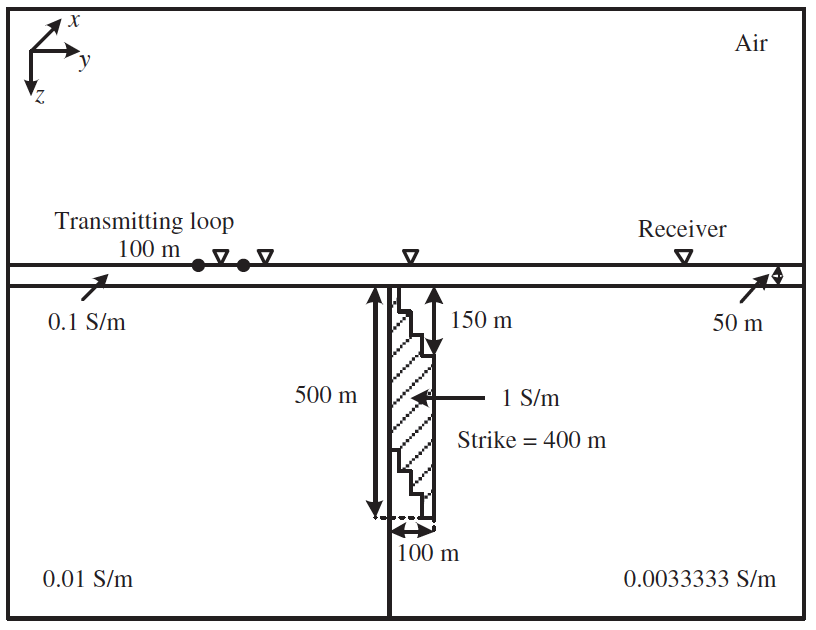

In [77]:
# create a 3d tensor mesh
cs = 25.                       # cell size
ncx, ncy, ncz = 24, 24, 44     # number of cells in x, y, z
npad = 18                      # number of padding cells
pad_rate = 1.3                 # padding rate
hx = [(cs,npad,-pad_rate), (cs,ncx), (cs,npad,pad_rate)]
hy = [(cs,npad,-pad_rate), (cs,ncy), (cs,npad,pad_rate)]
hz = [(cs,npad,-pad_rate), (cs,ncz), (cs,npad,pad_rate)]
mesh = mesh([hx,hy,hz], 'CCC') # create a mesh

print(mesh)



  TensorMesh: 288,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     60    -12,374.34     12,374.34     25.00  2,811.39    1.30
   y     60    -12,374.34     12,374.34     25.00  2,811.39    1.30
   z     80    -12,624.34     12,624.34     25.00  2,811.39    1.30




In [78]:
# time channel & diffusion distance
time = np.logspace(np.log10(1e-4), np.log10(4e-2), 100) # starting time, ending time, number of time channels

# minimum diffusion distance = 1260*sqrt(rho_min * time_early), used to estimate the smallest cell size
print("minimum diffusion distance: {:1.3e} m".format(1260*np.sqrt(1*time[0]))) 

# maximum diffusion distance = 1260*sqrt(rho_max * time_late), used to estimate the range of padding
print("maximum diffusion distance: {:1.3e} m".format(1260*np.sqrt(300*time[-1])))


minimum diffusion distance: 1.260e+01 m
maximum diffusion distance: 4.365e+03 m


In [79]:
# conductivity model parameters
sig_air = 1e-8             # air conductivity
sig_surface = 1e-1         # overburden conductivity
sig_half_left = 1e-2       # half-space (left) conductivity
sig_half_right = 1/3*1e-2  # half-space (right) conductivity
sig_slab = 1               # dipping slab conductivity

# add background model
sigma = np.ones(mesh.nC)*sig_half_right
sigma[mesh.gridCC[:,1]<0.] = sig_half_left
sigma[mesh.gridCC[:,2]>-50.] = sig_surface
sigma[mesh.gridCC[:,2]>0.] = sig_air

# add dipping slab model 
blk1 = utils.ModelBuilder.getIndicesBlock(
    np.r_[-200, 25, -50],
    np.r_[200, 0, -400], 
    mesh.gridCC
)
blk2 = utils.ModelBuilder.getIndicesBlock(
    np.r_[-200, 50, -100],
    np.r_[200, 25, -450], 
    mesh.gridCC
)
blk3 = utils.ModelBuilder.getIndicesBlock(
    np.r_[-200, 75, -150],
    np.r_[200, 50, -500], 
    mesh.gridCC
)
blk4 = utils.ModelBuilder.getIndicesBlock(
    np.r_[-200, 100, -200],
    np.r_[200, 75, -550], 
    mesh.gridCC
)
sigma[blk1] = sig_slab
sigma[blk2] = sig_slab
sigma[blk3] = sig_slab
sigma[blk4] = sig_slab


In [80]:
# assemble survey
y = np.array([-350,-250,50,650]) # y-coordinates of receivers
x = np.array([0,0,0,0])          # x-coordinates of receivers

location_r = np.zeros((len(y),3)) # receiver locations
for iy in range(len(y)):
    location_r[iy,:] = np.array([[x[iy], y[iy], 0.]]) # receiver locations x,y,z in array
rx_z = TDEM.Rx.Point_dbdt(location_r, time, 'z') # dbdt receiver: location, time, component

# Option 1: line current source
location_s = np.array([[50,-400,0],[50,-300,0],[-50,-300,0],[-50,-400,0],[50,-400,0]]) # source path
src = TDEM.Src.LineCurrent([rx_z], loc=location_s)

# Option 2: circular loop source
# location_s = np.array([[0,-350,0]]) # loop center
# src = TDEM.Src.CircularLoop([rx_z], orientation='z', loc=location_s, radius=np.sqrt(1e4/np.pi), current=1)

# add to source list
srcList = []
srcList.append(src)


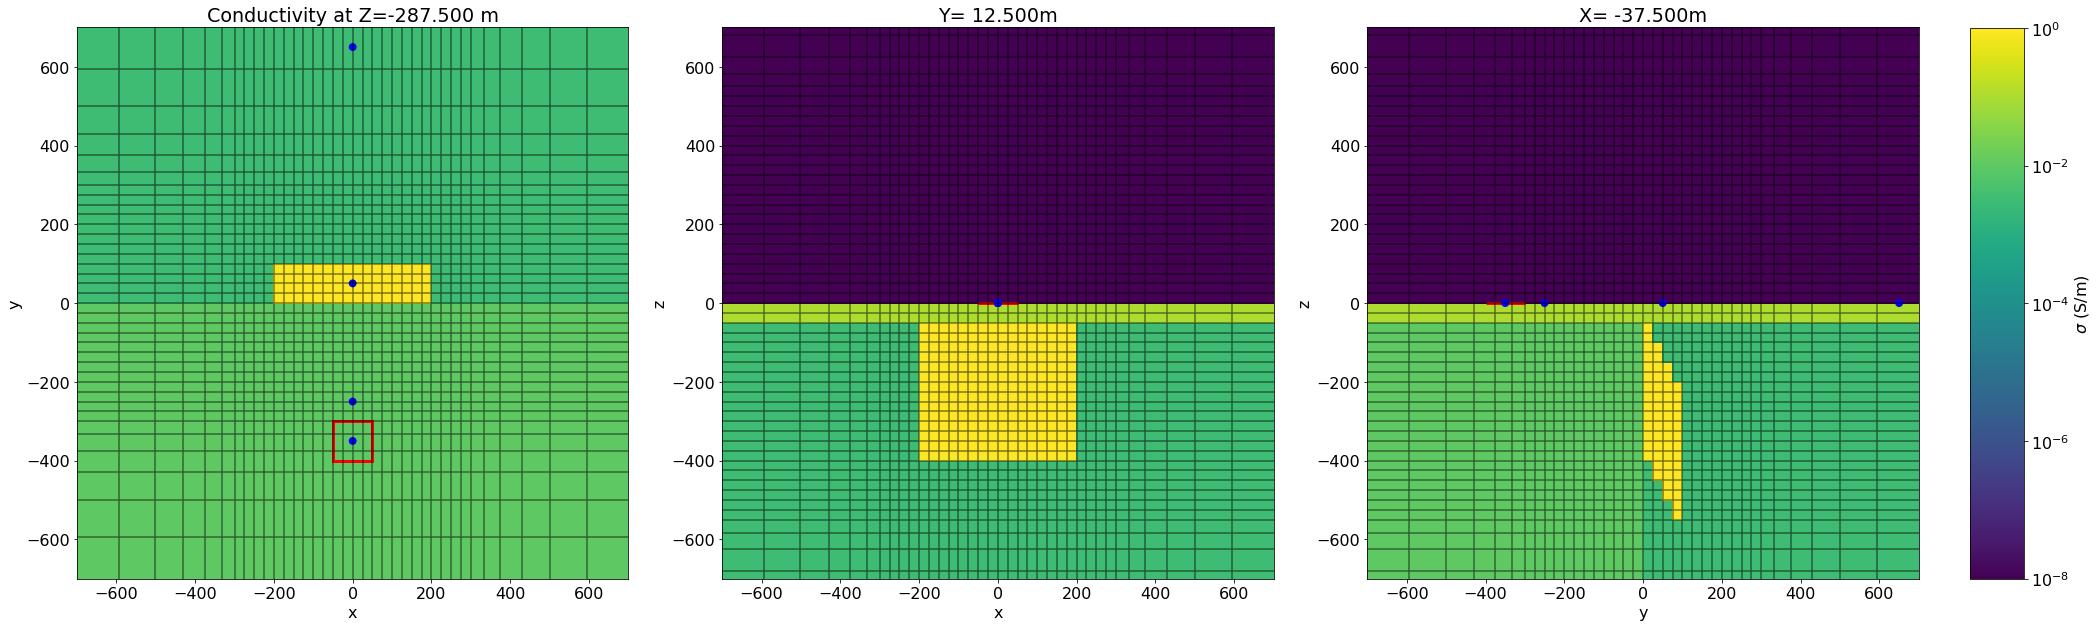

In [81]:
# plot model
indx = 28 # slice x-index
indy = 30 # slice y-index
indz = 28 # slice z-index

fig, ax = plt.subplots(1,3, figsize = (30, 9))
clim = [1e-8, 1]

# plot slices of the model in x, y, z
dat1 = mesh.plotSlice(sigma, grid=True, ax=ax[0], ind=indz, pcolorOpts={'norm':LogNorm()}, clim=clim)
dat2 = mesh.plotSlice(sigma, grid=True, ax=ax[1], ind=indy, normal='Y', pcolorOpts={'norm':LogNorm()}, clim=clim)
dat3 = mesh.plotSlice(sigma, grid=True, ax=ax[2], ind=indy, normal='X', pcolorOpts={'norm':LogNorm()}, clim=clim)

# set axis limits
xlim = [-700., 700.]
ylim = [-700., 700.]
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim)
ax[2].set_xlim(xlim)
ax[2].set_ylim(ylim)

# set aspect ratio
plt.tight_layout()
ax[0].set_aspect(1)
ax[1].set_aspect(1)
ax[2].set_aspect(1)

# set titles
ax[0].set_title("Conductivity at Z={:1.3f} m".format(mesh.vectorCCz[indz]))
ax[1].set_title("Y= {:1.3f}m".format(mesh.vectorCCy[indy]))
ax[2].set_title("X= {:1.3f}m".format(mesh.vectorCCx[indx]))

# set color bar
fig.subplots_adjust(right=0.9) 
l = 0.92
b = 0.09
w = 0.025
h = 0.85
rect = [l,b,w,h] 
cbar_ax = fig.add_axes(rect) 
cb=plt.colorbar(dat3[0],ax = ax[0], cax=cbar_ax)
cb.set_label("$\sigma$ (S/m)")

# plot the source as red lines
ax[0].add_patch(Rectangle((min(location_s[:,0]), min(location_s[:,1])), max(location_s[:,0])-min(location_s[:,0]),\
                          max(location_s[:,1])-min(location_s[:,1]),fill=False,linewidth=3,edgecolor="red"))
ax[1].add_patch(Rectangle((min(location_s[:,0]), 0), max(location_s[:,0])-min(location_s[:,0]),\
                          0.1,fill=False,linewidth=3,edgecolor="red"))
ax[2].add_patch(Rectangle((min(location_s[:,1]),0), max(location_s[:,1])-min(location_s[:,1]),\
                          0.1,fill=False,linewidth=3,edgecolor="red"))

# plot the receivers as blue dots
for i in range(len(y)):
    ax[0].add_patch(Circle(xy=(x[i], y[i]), radius=10,fc='blue'))
for i in range(len(y)):
    ax[1].add_patch(Circle(xy=(x[i],0 ), radius=10,fc='blue'))
for i in range(len(y)):
    ax[2].add_patch(Circle(xy=(y[i],0 ), radius=10,fc='blue'))


# fig.savefig('./figures/model.png', dpi=350) # save figure to disk



In [82]:
# set up the forward simulation
timesteps = [(1e-6,10),(3*1e-6,20),(3**2*1e-6,30),(3**3*1e-6,30),(3**4*1e-6,30),\
             (3**5*1e-6,30),(3**6*1e-6,30),(3**7*1e-6,10)] # (step size, number of steps), (step size, number of steps), ...

prb = TDEM.Problem3D_e(mesh, Solver=Pardiso, verbose=True, timeSteps=timesteps, sigmaMap=maps.IdentityMap(mesh))
survey = TDEM.Survey(srcList)
survey.pair(prb)


In [ ]:
%%time
# solve the forward simulation
fields = prb.fields(sigma) # plug in the conductivity model


Calculating Initial fields
Factoring the system matrix for the DC problem
**************************************************
Calculating fields(m)
**************************************************
Factoring...   (dt = 1.000000e-06)
Done
    Solving...   (tInd = 1)
    Done...
    Solving...   (tInd = 2)
    Done...
    Solving...   (tInd = 3)
    Done...
    Solving...   (tInd = 4)
    Done...
    Solving...   (tInd = 5)
    Done...
    Solving...   (tInd = 6)
    Done...
    Solving...   (tInd = 7)
    Done...
    Solving...   (tInd = 8)
    Done...
    Solving...   (tInd = 9)
    Done...
    Solving...   (tInd = 10)
    Done...
Factoring...   (dt = 3.000000e-06)
Done
    Solving...   (tInd = 11)
    Done...
    Solving...   (tInd = 12)
    Done...
    Solving...   (tInd = 13)
    Done...
    Solving...   (tInd = 14)
    Done...
    Solving...   (tInd = 15)
    Done...
    Solving...   (tInd = 16)
    Done...
    Solving...   (tInd = 17)
    Done...
    Solving...   (tInd = 18)
    D

In [ ]:
# retrieve data
dpred = survey.dpred(sigma, f=fields) # get data from computed fields
DPRED = dpred.reshape((survey.nSrc, rx_z.times.size, rx_z.locs[:,0].size)) # form a data array

np.save('/root/data/dpred.npy', dpred)


In [ ]:
# plot data as decay curves
fig = plt.figure(figsize=(9, 4), dpi=350)

plt.loglog(time,np.abs(DPRED[0,:,0]), 'k.-', lw=1) # Rx 1
plt.loglog(time,np.abs(DPRED[0,:,1]), '.-', lw=1)  # Rx 2
plt.loglog(time,np.abs(DPRED[0,:,2]), '.-', lw=1)  # Rx 3
plt.loglog(time,np.abs(DPRED[0,:,3]), '.-', lw=1)  # Rx 4

plt.xlabel("t (s)")
plt.ylabel("Voltage (V/Am$^2$)")
plt.legend(['y=-350m','y=-250m','y=50m','y=650m'])
plt.grid(which="both", alpha=0.2)

# fig.savefig('./figures/data_decay_curves.png', dpi=350, bbox_inches="tight")


In [ ]:
# load FDTD solutions (Sun et al., 2018)
data1 = pd.read_table('/root/data/50.dat', header=None)
data1 = np.array(data1)
data2 = pd.read_table('/root/data/150.dat', header=None)
data2 = np.array(data2)
data3 = pd.read_table('/root/data/450.dat', header=None)
data3 = np.array(data3)
data4 = pd.read_table('/root/data/1050.dat', header=None)
data4 = np.array(data4)

# load SimPEG solutions
dpred = np.load('/root/data/dpred.npy')
DPRED = dpred.reshape((survey.nSrc, rx_z.times.size, rx_z.locs[:,0].size))


In [ ]:
# plot SimPEG and FDTD solutions for comparison
for i in range(len(y)):
    j=i+1
    data=eval('data'+str(j))
    fig = plt.figure(figsize=(9, 2.5), dpi=350)

    plt.loglog(time,np.abs(DPRED[0,:,i]), 'r.-', lw=1)
    plt.loglog(data[350:2000,0],data[350:2000,1],'b-',lw=1)

    plt.xlabel("t (s)")
    plt.ylabel("Voltage (V/Am$^2$)")
    plt.grid(which="both", alpha=0.2)
    plt.legend(['SimPEG','FDTD'])
    title='('+chr(97+i)+')Y='+str(y[i])+'m'
    plt.title(title)

    fig = plt.figure(figsize=(9, 2.5), dpi=350)

    f=interpolate.interp1d(data[:,0],data[:,1],kind='cubic')
    f1=f(time)
    f2=np.abs(DPRED[0,:,i])
    plt.loglog(time,np.abs((f1-f2)/f1), 'r.-', lw=1)
    rms=np.abs((f1-f2)/f1)

    plt.xlabel("t (s)")
    plt.ylabel("relative error")
    plt.ylim(1e-3,1)
    plt.grid(which="both", alpha=0.2)
    plt.legend(['relative error'])
  